# The Stuart-Landau Oscillator

A simplified Hopf normal form for modeling neural oscillations near bifurcation.

## Learning Objectives

By the end of this tutorial, you will be able to:

- Understand the Stuart-Landau equations and their relationship to the Hopf oscillator
- Explain why the amplitude saturates at $\sqrt{a}$ for $a > 0$
- Simulate Stuart-Landau oscillators with noise
- Compare Stuart-Landau with the full Hopf model

## Background / Theory

### The Stuart-Landau Equations

The **Stuart-Landau oscillator** is the canonical normal form for dynamics near a supercritical Hopf bifurcation. It is closely related to the Hopf model but uses a simpler amplitude saturation term.

The equations in real coordinates $(x, y)$:

$$
\begin{aligned}
\dot{x} &= (a - r^2)x - \omega y + I_x(t) \\
\dot{y} &= (a - r^2)y + \omega x + I_y(t)
\end{aligned}
$$

where $r^2 = x^2 + y^2$.

### Comparison with Hopf Model

| Feature | Stuart-Landau | Hopf (with $\beta$) |
|---------|---------------|---------------------|
| Amplitude term | $(a - r^2)$ | $(a - \beta r^2)$ |
| Limit cycle radius | $\sqrt{a}$ | $\sqrt{a/\beta}$ |
| Parameters | 2 ($a$, $\omega$) | 3 ($a$, $\omega$, $\beta$) |

The Stuart-Landau model is equivalent to Hopf with $\beta = 1$.

### Why Use Stuart-Landau?

1. **Simplicity**: Fewer parameters to tune
2. **Direct amplitude control**: The parameter $a$ directly sets the limit cycle radius
3. **Canonical form**: Standard in dynamical systems literature

## Implementation

### Step 1: Setup and Imports

In [1]:
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

import brainmass
import brainstate

# Set simulation time step
brainstate.environ.set(dt=0.1 * u.ms)

### Step 2: Single Node Simulation

Create a Stuart-Landau oscillator above the bifurcation point:

In [2]:
# Create Stuart-Landau oscillator
node = brainmass.StuartLandauStep(
    1,  # single node
    a=0.5,  # bifurcation parameter (a > 0 -> oscillation)
    w=0.3,  # angular frequency
    noise_x=brainmass.OUProcess(1, sigma=0.02, tau=5.0 * u.ms),
    noise_y=brainmass.OUProcess(1, sigma=0.02, tau=5.0 * u.ms),
)

# Initialize states
node.init_all_states()

# Set non-zero initial condition
node.x.value = np.array([0.1])
node.y.value = np.array([0.1])

print(f"Expected limit cycle radius: sqrt({node.a.value()}) = {np.sqrt(node.a.value()):.3f}")



Expected limit cycle radius: sqrt(0.5) = 0.707


In [3]:
# Define simulation step
def step_run(i):
    node.update()
    return node.x.value, node.y.value


# Run simulation (1000 ms)
indices = np.arange(10000)
x_trace, y_trace = brainstate.transform.for_loop(step_run, indices)

### Step 3: Visualize Dynamics

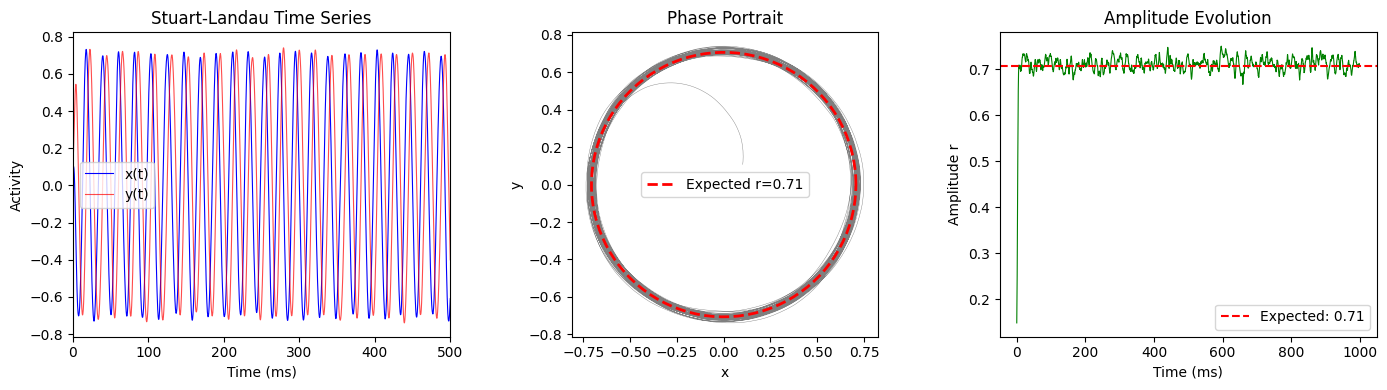

In [4]:
t_ms = indices * brainstate.environ.get_dt()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Time series
axes[0].plot(t_ms, x_trace[:, 0], 'b-', label='x(t)', linewidth=0.8)
axes[0].plot(t_ms, y_trace[:, 0], 'r-', label='y(t)', linewidth=0.8, alpha=0.7)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Activity')
axes[0].set_title('Stuart-Landau Time Series')
axes[0].legend()
axes[0].set_xlim([0, 500])

# Phase portrait
axes[1].plot(x_trace[:, 0], y_trace[:, 0], 'k-', linewidth=0.3, alpha=0.5)
# Draw expected limit cycle
theta = np.linspace(0, 2 * np.pi, 100)
r_expected = np.sqrt(node.a.value())
axes[1].plot(r_expected * np.cos(theta), r_expected * np.sin(theta),
             'r--', linewidth=2, label=f'Expected r={r_expected:.2f}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Phase Portrait')
axes[1].set_aspect('equal')
axes[1].legend()

# Amplitude over time
r_trace = np.sqrt(x_trace[:, 0] ** 2 + y_trace[:, 0] ** 2)
axes[2].plot(t_ms, r_trace, 'g-', linewidth=0.8)
axes[2].axhline(r_expected, color='r', linestyle='--', label=f'Expected: {r_expected:.2f}')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Amplitude r')
axes[2].set_title('Amplitude Evolution')
axes[2].legend()

plt.tight_layout()
plt.show()



### Step 4: Amplitude Depends on Parameter $a$

The key property of Stuart-Landau: the limit cycle radius is exactly $\sqrt{a}$.

In [5]:
@brainstate.transform.jit
def simulate_a_trial(a):
    model = brainmass.StuartLandauStep(1, a=a, w=0.3)
    model.init_all_states()
    model.x.value = np.array([0.1])
    model.y.value = np.array([0.1])

    # Simulate
    def step(i):
        model.update()
        return model.x.value, model.y.value

    x, y = brainstate.transform.for_loop(step, np.arange(5000))
    return x, y



<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
C:\Users\adadu\AppData\Local\Temp\ipykernel_37856\1975205603.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.suptitle('Limit Cycle Radius = $\sqrt{a}$', y=1.02, fontsize=14)


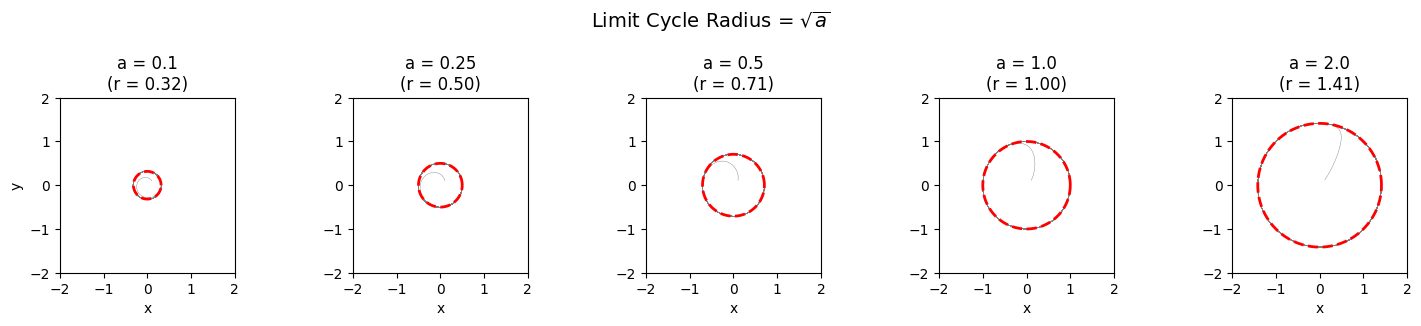

In [6]:
# Sweep different values of a
a_values = np.array([0.1, 0.25, 0.5, 1.0, 2.0])

fig, axes = plt.subplots(1, len(a_values), figsize=(15, 3))

for idx, a_val in enumerate(a_values):
    # Create oscillator
    x, y = simulate_a_trial(a_val)

    # Plot phase portrait
    axes[idx].plot(x[:, 0], y[:, 0], 'k-', linewidth=0.3, alpha=0.5)

    # Expected circle
    theta = np.linspace(0, 2 * np.pi, 100)
    r = np.sqrt(a_val)
    axes[idx].plot(r * np.cos(theta), r * np.sin(theta), 'r--', linewidth=2)

    axes[idx].set_xlim([-2, 2])
    axes[idx].set_ylim([-2, 2])
    axes[idx].set_aspect('equal')
    axes[idx].set_title(f'a = {a_val}\n(r = {r:.2f})')
    axes[idx].set_xlabel('x')
    if idx == 0:
        axes[idx].set_ylabel('y')

plt.suptitle('Limit Cycle Radius = $\sqrt{a}$', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### Step 5: Comparison with Hopf Model

Stuart-Landau is equivalent to Hopf with $\beta = 1$:

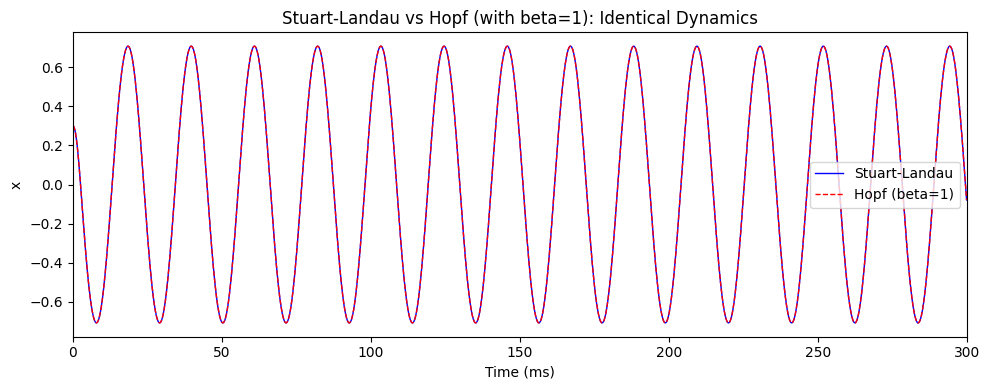

Maximum difference: 7.45e-09 (should be ~0 or numerical precision)


In [7]:
# Create both models with same parameters
a, w = 0.5, 0.3

sl_model = brainmass.StuartLandauStep(1, a=a, w=w)
hopf_model = brainmass.HopfStep(1, a=a, w=w, beta=1.0)  # beta=1 makes it equivalent

# Initialize both
sl_model.init_all_states()
hopf_model.init_all_states()


# Simulate both
def step_sl(i):
    sl_model.update()
    return sl_model.x.value


# Same initial conditions
sl_model.x.value = np.array([0.3])
sl_model.y.value = np.array([0.3])
indices = np.arange(3000)
x_sl = brainstate.transform.for_loop(step_sl, indices)


def step_hopf(i):
    hopf_model.update()
    return hopf_model.x.value


# Re-init Hopf for fair comparison
hopf_model.init_all_states()
hopf_model.x.value = np.array([0.3])
hopf_model.y.value = np.array([0.3])
x_hopf = brainstate.transform.for_loop(step_hopf, indices)

# Plot comparison
t_ms = indices * brainstate.environ.get_dt()

plt.figure(figsize=(10, 4))
plt.plot(t_ms, x_sl[:, 0], 'b-', label='Stuart-Landau', linewidth=1)
plt.plot(t_ms, x_hopf[:, 0], 'r--', label='Hopf (beta=1)', linewidth=1)
plt.xlabel('Time (ms)')
plt.ylabel('x')
plt.title('Stuart-Landau vs Hopf (with beta=1): Identical Dynamics')
plt.legend()
plt.xlim([0, 300])
plt.tight_layout()
plt.show()

# Check numerical difference
diff = np.abs(x_sl - x_hopf).max()
print(f"Maximum difference: {diff:.2e} (should be ~0 or numerical precision)")

### Step 6: Bifurcation diagram

In [8]:
a_vals = np.linspace(-2, 2, 50)  # 50 points

nodes = brainmass.StuartLandauStep(
    a_vals.size, a=a_vals, w=0.3,
    init_x=braintools.init.Uniform(0, 1),
    init_y=braintools.init.Uniform(0, 1),
)
nodes.init_all_states()


def step_run(i):
    return nodes.update()


indices = np.arange(20000)
x_trace = brainstate.transform.for_loop(step_run, indices)[0]
x_last = x_trace[-5000:]  # shape (5000, 50)
max_x = x_last.max(axis=0)
min_x = x_last.min(axis=0)

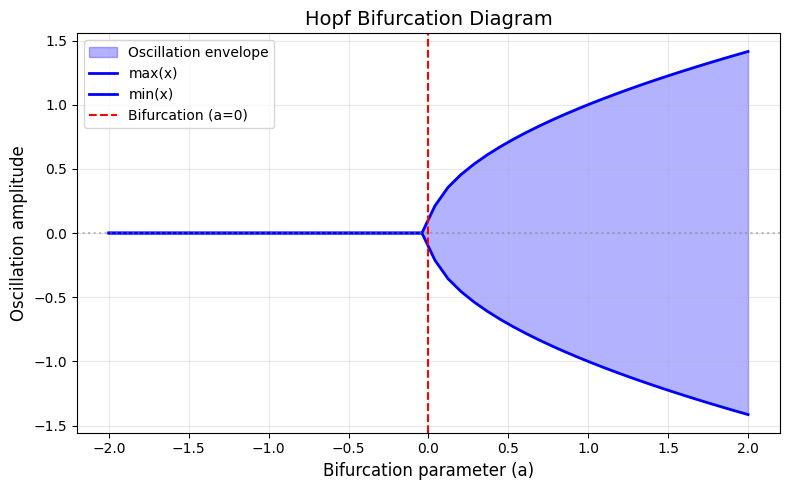

In [9]:
plt.figure(figsize=(8, 5))
plt.fill_between(a_vals, min_x, max_x, alpha=0.3, color='blue', label='Oscillation envelope')
plt.plot(a_vals, max_x, 'b-', lw=2, label='max(x)')
plt.plot(a_vals, min_x, 'b-', lw=2, label='min(x)')
plt.axvline(0.0, ls='--', color='red', label='Bifurcation (a=0)')
plt.axhline(0.0, ls=':', color='gray', alpha=0.5)

plt.xlabel('Bifurcation parameter (a)', fontsize=12)
plt.ylabel('Oscillation amplitude', fontsize=12)
plt.title('Hopf Bifurcation Diagram', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Exercises

### Exercise 1: Subcritical Dynamics

Set $a = -0.1$ and observe the dynamics:
1. What happens to the oscillation?
2. Add strong noise - can noise sustain oscillations in the subcritical regime?

### Exercise 2: Frequency Sweep

Keep $a = 0.5$ fixed and vary $\omega$ from 0.1 to 1.0:
1. How does the oscillation period change?
2. Does $\omega$ affect the amplitude?

### Exercise 3: Network of Stuart-Landau Oscillators

Create a small network of 5 coupled Stuart-Landau oscillators:

```python
# Hint: Use diffusive coupling similar to Hopf network in tutorial 010
n_nodes = 5
nodes = brainmass.StuartLandauStep(n_nodes, a=0.5, w=0.3)
# Add coupling...
```

Investigate how coupling affects synchronization.

## References

1. Stuart, J. T. (1960). On the non-linear mechanics of wave disturbances in stable and unstable parallel flows. *Journal of Fluid Mechanics*, 9(3), 353-370.

2. Landau, L. D. (1944). On the problem of turbulence. *Dokl. Akad. Nauk SSSR*, 44, 339.

3. Strogatz, S. H. (2015). *Nonlinear Dynamics and Chaos*. Westview Press. (Chapter 8)
